In [18]:
import numpy as np
import torch.nn as nn
from dataset import CityscapesDataset
from torchvision.datasets import Cityscapes
import torch.nn.functional as F
from PreNet import *
from unet import *
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os 
from tqdm import trange

In [19]:
# ALL CREDITS TO https://github.com/goldbattle/pytorch_unet/blob/master/script_train.py FOR DATASET CLASS!
# path = "/Users/charlesdowns/Desktop/cityscapes_mini/" # Mini dataset on Macbook
path = "/home/charles/Desktop/cityscapes"
img_data = CityscapesDataset(path, split='train', mode='fine')
batch_size = 8
img_batch = torch.utils.data.DataLoader(img_data, batch_size=batch_size, shuffle=True, num_workers=16)

In [20]:
# Hyperparameters and stuff
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

# Set model parameters
epochs = 10
learning_rate = 0.0001
in_c = 3

# Create the model
in_channels = 3 # Raw RGB image
hidden_channels = [16, 32, 128, 16, 64, 3]
out_features = 3 # GenISP output channels
PreNet = PreNet( in_channels, hidden_channels, out_features)
UNet = UNet(in_c, img_data.num_classes, 64)
# Net = nn.Sequential(PreNet,UNet)
PreNet.to(device)
UNet.to(device)
train_loss = []
UNet.load_state_dict(torch.load("model.pth"))

for param in UNet.parameters():
    param.requires_grad = False # Freeze the UNet weights

# Since our goal here is to segment, we will use the cross entropy loss function and 4 classes (background, road, sky, car)
criterion = nn.CrossEntropyLoss() # for segment loss. could also be reconstruction loss, then it is N1 loss 
num_classes = img_data.num_classes
print(num_classes)
optimizer = torch.optim.Adam(PreNet.parameters(), lr=learning_rate)

cuda:0
4


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/10, Batch: 1/372, Loss: 0.4044


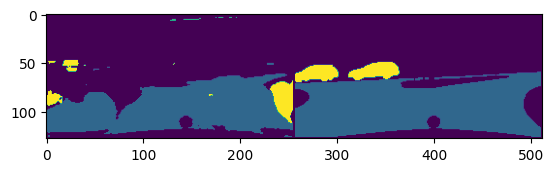

Epochs:  10%|█         | 1/10 [01:38<14:45, 98.38s/it]

Epoch: 2/10, Batch: 1/372, Loss: 0.1483


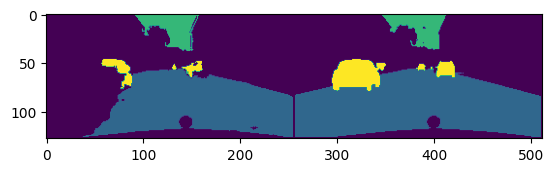

Epochs:  20%|██        | 2/10 [03:14<12:58, 97.34s/it]

Epoch: 3/10, Batch: 1/372, Loss: 0.1344


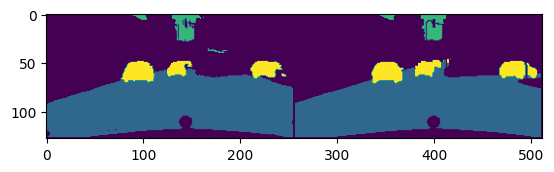

Epochs:  30%|███       | 3/10 [04:51<11:17, 96.80s/it]

Epoch: 4/10, Batch: 1/372, Loss: 0.0929


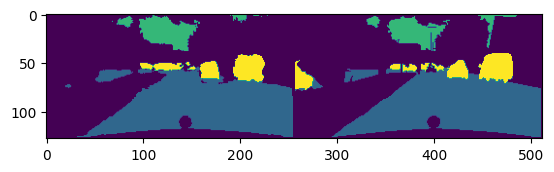

Epochs:  40%|████      | 4/10 [06:25<09:35, 95.98s/it]

Epoch: 5/10, Batch: 1/372, Loss: 0.0910


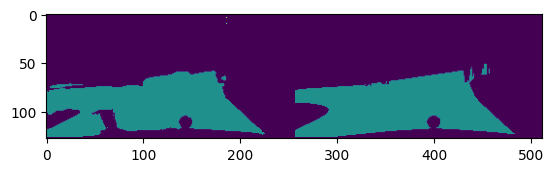

Epochs:  50%|█████     | 5/10 [07:58<07:53, 94.63s/it]

Epoch: 6/10, Batch: 1/372, Loss: 0.1057


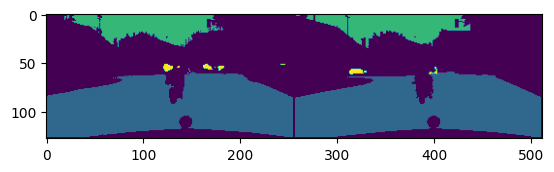

Epochs:  60%|██████    | 6/10 [09:31<06:17, 94.26s/it]

Epoch: 7/10, Batch: 1/372, Loss: 0.1401


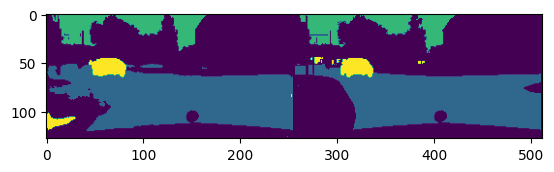

Epochs:  70%|███████   | 7/10 [11:04<04:41, 93.95s/it]

Epoch: 8/10, Batch: 1/372, Loss: 0.1324


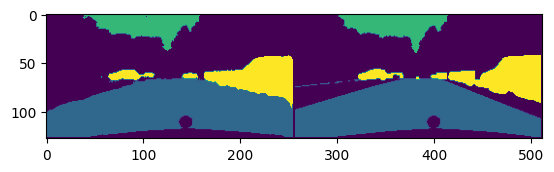

Epochs:  80%|████████  | 8/10 [12:38<03:07, 93.79s/it]

Epoch: 9/10, Batch: 1/372, Loss: 0.1052


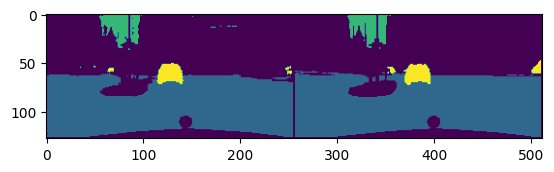

Epochs:  90%|█████████ | 9/10 [14:11<01:33, 93.61s/it]

Epoch: 10/10, Batch: 1/372, Loss: 0.0994


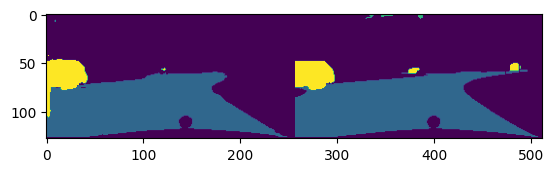

Epochs: 100%|██████████| 10/10 [15:44<00:00, 94.50s/it]


In [21]:
t = trange(epochs, desc="Epochs", leave=True)
for epoch in t:
    # TODO: use tqdm for progress bar
    for idx_batch, (imagergb, labelmask, labelrgb) in enumerate(img_batch):
        imagergb = imagergb.to(device)
        labelmask = labelmask.to(device)
        labelrgb = labelrgb.to(device)
        # print(imagergb.shape)
        optimizer.zero_grad()
        # net = nn.Sequential(PreNet, F.pad(input=PreNet(imagergb), pad=(2, 2, 2, 2)),UNet)
        output1 = PreNet(imagergb)
        output2 = F.pad(input=output1, pad=(2, 2, 2, 2))
    
        output = UNet(output2)
        loss = criterion(output, labelmask)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

        if idx_batch % 1000 == 0:
            print("Epoch: {}/{}, Batch: {}/{}, Loss: {:.4f}".format(epoch+1, epochs, idx_batch+1, len(img_batch), loss.item()))
            # Display the output and ground truth next to eachother 
            output = output.detach().cpu().numpy()
            output = np.argmax(output, axis=1)
            output_batch = output.shape[0]
            output = output.reshape((output_batch, output.shape[1], output.shape[2]))
            # output = output.reshape((output.shape[1], output.shape[2]))


            labelmask = labelmask.detach().cpu().numpy()
            labelmast_batch = labelmask.shape[0]
            labelmask = labelmask.reshape((labelmast_batch, labelmask.shape[1], labelmask.shape[2]))
            # labelmask = labelmask.reshape((labelmask.shape[1], labelmask.shape[2]))
            # plt.imshow(output)
            # plt.show()
            # plt.imshow(labelmask)
            # plt.show()
            
            
            # concat output and labelmask
            output = np.concatenate((output, labelmask), axis=2)
            plt.imshow(output[1])
            plt.show()


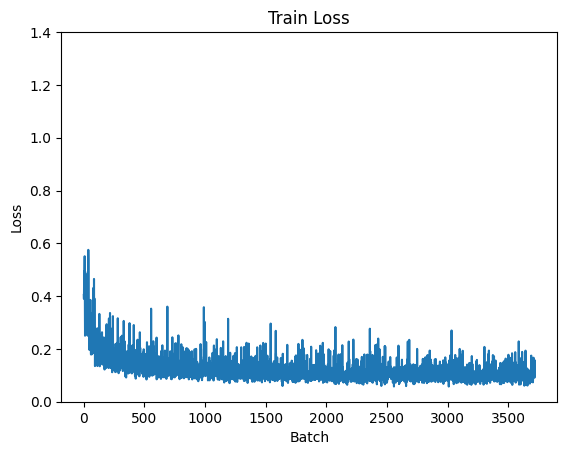

Saved PyTorch Model State to model.pth


In [24]:
# Plot the training loss
plt.plot(train_loss)
plt.title("Train Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
# set y-label to 1.4
plt.ylim(0, 1.4)
plt.show()


# Save the model
torch.save(PreNet.state_dict(), "prenet_model.pth")
print("Saved PyTorch Model State to model.pth")


In [23]:
# Print the weights and biases of first two layers
for param in PreNet.parameters():
    print(param.data)
    average_weight = torch.mean(param.data)

print(average_weight)
    

tensor([[[[ 0.0298, -0.0116,  0.0006,  ..., -0.0702, -0.0405, -0.0769],
          [ 0.0145, -0.0040, -0.0618,  ...,  0.0488, -0.0191,  0.0498],
          [ 0.0441,  0.0364, -0.0285,  ...,  0.0705,  0.0677,  0.0679],
          ...,
          [ 0.0118, -0.0407, -0.0508,  ..., -0.0365, -0.0257, -0.0325],
          [-0.0578,  0.0402,  0.0583,  ..., -0.0622, -0.0214,  0.0678],
          [-0.0041,  0.0455, -0.0075,  ..., -0.0279, -0.0729,  0.0019]],

         [[-0.0627,  0.0669,  0.0236,  ..., -0.0299,  0.0753, -0.0587],
          [-0.0264,  0.0433, -0.0560,  ..., -0.0812,  0.0205, -0.0778],
          [ 0.0071, -0.0135, -0.0349,  ..., -0.0195,  0.0391,  0.0755],
          ...,
          [-0.0434,  0.0414,  0.0792,  ..., -0.0039,  0.0044, -0.0567],
          [-0.0418, -0.0333,  0.0530,  ...,  0.0235,  0.0106,  0.0053],
          [ 0.0243, -0.0129,  0.0133,  ...,  0.0089, -0.0644,  0.0154]],

         [[-0.0504,  0.0577, -0.0837,  ...,  0.0256,  0.0027,  0.0230],
          [-0.0769, -0.0776,  